In [94]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Query Data

In [4]:
aws_engine = create_engine('postgresql://ubuntu@18.188.253.160:5432/ubuntu', echo=False)

In [30]:
query_data = """
with main as (
	select
		b.bill_id,
		-- author fields
		ia.np_score as author_ideology,
		pa.party_id as author_party,
		array_agg(pca.role) @> '{Chair}' as author_is_chair,
		pda.years_senate as author_years_sen,
		pda.total_funding as author_total_funding,
		-- sponsor fields
		count(distinct s.people_id) as total_sponsors,
		count(distinct s.people_id) filter (where ps.party_id = 1) as dem_sponsors,
		count(distinct s.people_id) filter (where ps.party_id = 2) as rep_sponsors,
		min(ids.np_score) as most_liberal_sponsor_ideology,
		max(ids.np_score) as most_cons_sponsor_ideology,
		count(distinct s.people_id) filter (where pcs.role = 'Chair') as sponsor_chairs,
		-- text
		b.description,
		-- target
		b.third_reading
	from sen_bill b
	left join author a on a.bill_id = b.bill_id
	left join people pa on pa.people_id = a.people_id
	left join ideology ia on a.people_id = ia.people_id
	left join people_committee pca on pca.people_id = a.people_id
	left join people_detail pda on pda.people_id = a.people_id
	left join sponsor_at_second s on s.bill_id = b.bill_id
	left join people ps on ps.people_id = s.people_id
	left join ideology ids on ids.people_id = s.people_id
	left join people_committee pcs on pcs.people_id = s.people_id
	left join people_detail pds on pds.people_id = s.people_id
	group by b.bill_id, b.third_reading, ia.np_score, pa.party_id, pda.years_senate, pda.total_funding, b.description
), agg_sponsors as (
	select 
		b.bill_id,
		sum(pd.total_funding) as agg_funding_sponsors,
		sum(pd.years_senate) as agg_exp_sponsors
	from sen_bill b
	join sponsor_at_second s on s.bill_id = b.bill_id
	join people_detail pd on pd.people_id = s.people_id
	group by b.bill_id
), slips as (
 SELECT
 	b.bill_id,
 	count(w.index) as total_slips,
 	count(w.index) filter (where w.position = 'PROP') as pro_slips,
 	count(w.index) filter (where w.position = 'OPP') as opp_slips,
 	count(w.index) filter (where w.position = 'NOPOS') as no_pos_slips
   FROM sen_bill b
   	 -- works b/c this join is 1x1 and does not duplicate records (should make index distinct)
     left JOIN history hs ON hs.bill_id = b.bill_id AND hs.action ~* '^second reading'::text AND hs.chamber = 'Senate'::text
     left JOIN witness_slip w on w.bill_number = b.bill_number and w.date <= to_date(hs.date, 'YYYY-MM-DD')
     group by b.bill_id
) select
    m.*,
    a.agg_funding_sponsors,
    a.agg_exp_sponsors,
    s.total_slips,
    s.pro_slips,
    s.opp_slips,
    no_pos_slips
from main m
left join agg_sponsors a on m.bill_id = a.bill_id
left join slips s on s.bill_id = m.bill_id;
"""

raw = pd.read_sql(query_data, con=aws_engine)

In [31]:
raw.describe()

,bill_id,author_ideology,author_party,author_years_sen,author_total_funding,total_sponsors,dem_sponsors,rep_sponsors,most_liberal_sponsor_ideology,most_cons_sponsor_ideology,sponsor_chairs,third_reading,agg_funding_sponsors,agg_exp_sponsors,total_slips,pro_slips,opp_slips,no_pos_slips
count,1.748000e+03,1468.000000,1541.000000,1539.000000,1.495000e+03,1748.000000,1748.000000,1748.000000,408.000000,408.000000,1748.000000,1748.000000,4.130000e+02,421.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,9.928618e+05,-0.429588,1.332901,15.964263,3.759754e+06,1.052632,0.820938,0.231693,-0.621912,-0.075385,0.623570,0.502860,5.191999e+06,38.320665,36.045195,19.566934,16.217963,0.260297
std,6.993044e+04,0.583068,0.471404,9.224728,3.301123e+06,3.269533,2.774790,0.926974,0.571558,0.585986,2.091538,0.500135,8.080010e+06,51.464405,266.063955,117.126689,194.661102,1.273337
min,9.074350e+05,-1.241000,1.000000,0.000000,9.948285e+04,0.000000,0.000000,0.000000,-1.241000,-1.241000,0.000000,0.000000,7.750307e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.295775e+05,-0.921000,1.000000,5.000000,6.410512e+05,0.000000,0.000000,0.000000,-1.081000,-0.481000,0.000000,0.000000,7.302204e+05,9.000000,0.000000,0.000000,0.000000,0.000000
50%,9.555885e+05,-0.706000,1.000000,20.000000,3.097623e+06,0.000000,0.000000,0.000000,-0.843000,-0.274500,0.000000,1.000000,1.617949e+06,18.000000,0.000000,0.000000,0.000000,0.000000
75%,1.083526e+06,0.266000,2.000000,26.000000,7.770649e+06,0.000000,0.000000,0.000000,-0.399000,0.434000,0.000000,1.000000,5.738434e+06,46.000000,5.000000,4.000000,0.000000,0.000000
max,1.112267e+06,0.812000,2.000000,26.000000,1.365498e+07,37.000000,33.000000,18.000000,0.812000,0.812000,25.000000,1.000000,5.117911e+07,347.000000,6986.000000,2475.000000,5882.000000,31.000000


In [32]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 20 columns):
bill_id                          1748 non-null int64
author_ideology                  1468 non-null float64
author_party                     1541 non-null float64
author_is_chair                  1748 non-null bool
author_years_sen                 1539 non-null float64
author_total_funding             1495 non-null float64
total_sponsors                   1748 non-null int64
dem_sponsors                     1748 non-null int64
rep_sponsors                     1748 non-null int64
most_liberal_sponsor_ideology    408 non-null float64
most_cons_sponsor_ideology       408 non-null float64
sponsor_chairs                   1748 non-null int64
description                      1748 non-null object
third_reading                    1748 non-null int64
agg_funding_sponsors             413 non-null float64
agg_exp_sponsors                 421 non-null float64
total_slips                      

In [33]:
raw[raw.total_sponsors > 0].shape
# big null counts for most_liberal/cons_ideol and agg_funding/exp are b/c only 421 had any sponsors
    # should be able to fill those with 0's
# leaves ~8 without agg funding
# leave ~13 without ideol range
# seems roughly proportional to the missing party, ideol, exp, funding in general (~200/1800)

(421, 20)

# Prep Data

In [119]:
model_data = raw.copy()

In [120]:
agg_columns = ['agg_funding_sponsors', 'agg_exp_sponsors']
for col in agg_columns:
    model_data[col] = model_data[col].where(model_data['total_sponsors'] > 0, 0)

In [121]:
def add_trivial_features(df: pd.DataFrame) -> None:
    df['slips_perc_pro'] = df.pro_slips / df.total_slips
    df['bipartisan'] = (df.dem_sponsors > 0) & (df.rep_sponsors > 0)
    df['bipartisan'] = df['bipartisan'].map(lambda x: 1 if x else 0)
    df['ideol_range'] = df.most_cons_sponsor_ideology - df.most_liberal_sponsor_ideology
    df['first_word_approp'] = df.description.map(lambda x: 1 if x.split(' ')[0] == 'Appropriates' else 0)
    df['author_is_chair'] = df['author_is_chair'].map(lambda x: 1 if x else 0)

In [122]:
def handle_nulls(df: pd.DataFrame) -> None:
    df.ideol_range = df.ideol_range.fillna(0)
    df.slips_perc_pro = df.slips_perc_pro.fillna(0)
    
    df.author_total_funding = df.author_total_funding.fillna(df.author_total_funding.mean())
    df.author_years_sen = df.author_years_sen.fillna(df.author_years_sen.mean())
    
    # assume missing people with no party are mode (dems in IL)
    df.author_ideology = df.author_ideology.fillna(df[df.author_party == 1].author_ideology.mean())
    df.author_party = df.author_party.fillna(1)
    
    avg_funding_per_sponsor = (df.agg_funding_sponsors / df.total_sponsors).mean()
    df.agg_funding_sponsors = df.agg_funding_sponsors.fillna(avg_funding_per_sponsor * df.total_sponsors)

In [123]:
add_trivial_features(model_data)

In [124]:
handle_nulls(model_data)

In [125]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 24 columns):
bill_id                          1748 non-null int64
author_ideology                  1748 non-null float64
author_party                     1748 non-null float64
author_is_chair                  1748 non-null int64
author_years_sen                 1748 non-null float64
author_total_funding             1748 non-null float64
total_sponsors                   1748 non-null int64
dem_sponsors                     1748 non-null int64
rep_sponsors                     1748 non-null int64
most_liberal_sponsor_ideology    408 non-null float64
most_cons_sponsor_ideology       408 non-null float64
sponsor_chairs                   1748 non-null int64
description                      1748 non-null object
third_reading                    1748 non-null int64
agg_funding_sponsors             1748 non-null float64
agg_exp_sponsors                 1748 non-null float64
total_slips                   

# Select First Feature Set

In [126]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
    'first_word_approp',
    'third_reading',
]

In [128]:
model_data[first_feature_set].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 15 columns):
author_ideology         1748 non-null float64
author_party            1748 non-null float64
author_is_chair         1748 non-null int64
author_years_sen        1748 non-null float64
author_total_funding    1748 non-null float64
total_sponsors          1748 non-null int64
sponsor_chairs          1748 non-null int64
agg_funding_sponsors    1748 non-null float64
agg_exp_sponsors        1748 non-null float64
total_slips             1748 non-null int64
slips_perc_pro          1748 non-null float64
bipartisan              1748 non-null int64
ideol_range             1748 non-null float64
first_word_approp       1748 non-null int64
third_reading           1748 non-null int64
dtypes: float64(8), int64(7)
memory usage: 205.0 KB


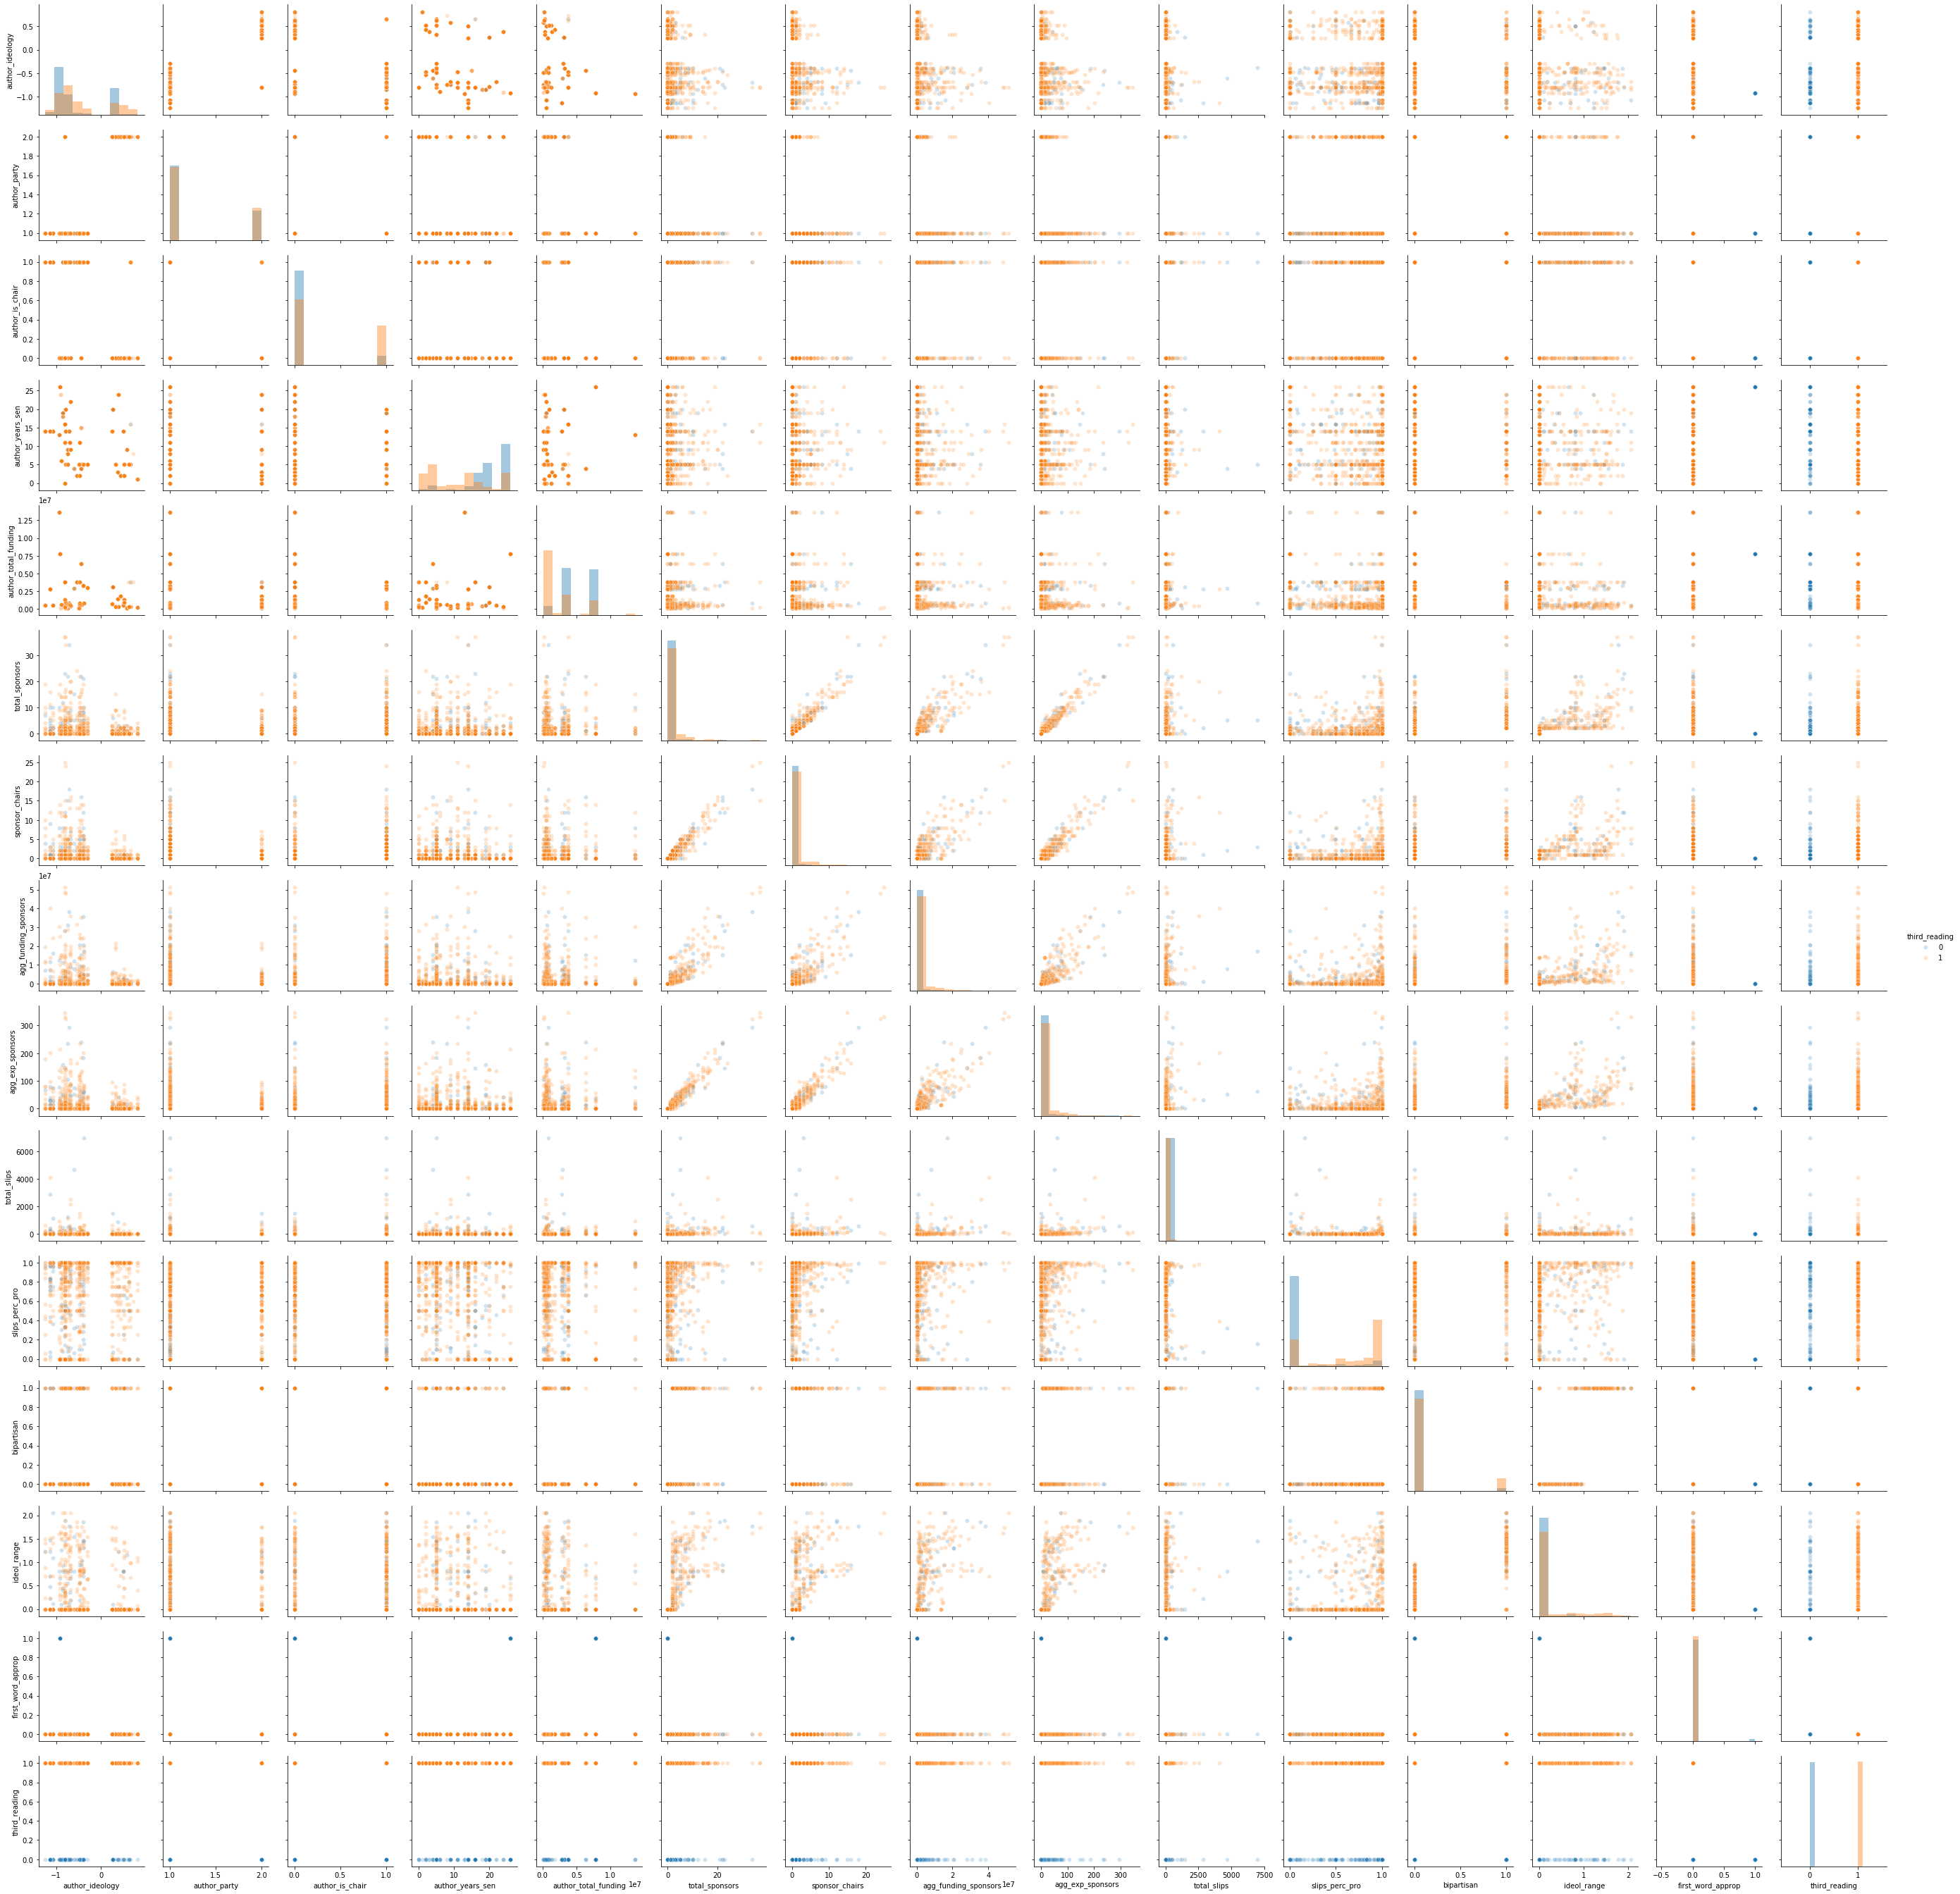

In [129]:
sns.pairplot(
    model_data[first_feature_set],
    plot_kws={ 'alpha': 0.2 },
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

In [ ]:
# Looks like I still have some signal after correcting the data
# author_ideol still needs some transformation to work with logistic regression
# scale on slips still makes it really hard to see patterns
# total_sponsors, sponsor_chairs, agg_funding, agg_exp are all pretty correlated
    # not sure how to read/treat categorical correlation
        # author_party and author_ideol are bound to be very correlated

# Baseline Models

In [130]:
target = 'third_reading'
X, y = model_data[first_feature_set].drop(columns=[target]), model_data[first_feature_set][target]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

## Dummy

In [132]:
dm = DummyClassifier(strategy='most_frequent')
dm.fit(X_train, y_train)
dm.score(X_test, y_test)

0.5028571428571429

## Default RF

In [133]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1398 entries, 1228 to 166
Data columns (total 14 columns):
author_ideology         1398 non-null float64
author_party            1398 non-null float64
author_is_chair         1398 non-null int64
author_years_sen        1398 non-null float64
author_total_funding    1398 non-null float64
total_sponsors          1398 non-null int64
sponsor_chairs          1398 non-null int64
agg_funding_sponsors    1398 non-null float64
agg_exp_sponsors        1398 non-null float64
total_slips             1398 non-null int64
slips_perc_pro          1398 non-null float64
bipartisan              1398 non-null int64
ideol_range             1398 non-null float64
first_word_approp       1398 non-null int64
dtypes: float64(8), int64(6)
memory usage: 163.8 KB


In [135]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('In sample:', rf.score(X_train, y_train))
print('Out of sample:', rf.score(X_test, y_test))

In sample: 0.9034334763948498
Out of sample: 0.8285714285714286


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
